In [327]:
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import galois
from mec import make_circle
from scipy.sparse import csr_matrix
from scipy.stats import skew

In [512]:
codes = [
    [6,6,3,1,2,3,1,2],
    [15,3,9,1,2,0,2,7],
    [6,9,3,1,2,3,1,2],
    [12,6,3,1,2,3,1,2],
    [12,12,3,2,7,3,1,2],
    [30,6,9,1,2,3,25,26],
    [21,18,3,10,17,5,3,19]
]
code = codes[3]

# code = [6,3,1,3,2,3,5,4,3,6,3,0] # used in the paper

# code = [12,5,10,4,1,0,1,2,5,12,2,0]  # this one .......
# code = [12,3,9,1,2,0,1,11,3,12,2,0]  # this one ......
# code = [15,5,5,2,3,2,7,6,15,5,0,4]  # this one ....... 10,8,15,5,5,2,3,2,7,6,15,5,0,4,1.5453514871063092,0.001,0.267,1001,1001,1.0
code = [14,7,6,5,6,0,4,13,7,14,0,2] # in the paper


code = [14,7,11,7,2,1,14,9,14,7,0,0] # 10, 4
code = [14,7,3,5,2,7,6,9,7,14,3,3] # 11,5


In [513]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

In [514]:
A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

In [515]:
Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)
# H = np.vstack([Hx, Hz])

In [516]:
def to_mtx(H):
    print("%%MatrixMarket matrix coordinate integer general\n")
    print(f"{H.shape[0]} {H.shape[1]} {np.count_nonzero(H)}")

    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if H[i][j]:
                print(f"{i+1} {j+1} 1")
to_mtx(Hz)

%%MatrixMarket matrix coordinate integer general

98 196 588
1 1 1
1 36 1
1 57 1
1 101 1
1 104 1
1 176 1
2 2 1
2 37 1
2 58 1
2 102 1
2 105 1
2 177 1
3 3 1
3 38 1
3 59 1
3 99 1
3 103 1
3 178 1
4 4 1
4 39 1
4 60 1
4 100 1
4 104 1
4 179 1
5 5 1
5 40 1
5 61 1
5 101 1
5 105 1
5 180 1
6 6 1
6 41 1
6 62 1
6 99 1
6 102 1
6 181 1
7 7 1
7 42 1
7 63 1
7 100 1
7 103 1
7 182 1
8 8 1
8 43 1
8 64 1
8 108 1
8 111 1
8 183 1
9 9 1
9 44 1
9 65 1
9 109 1
9 112 1
9 184 1
10 10 1
10 45 1
10 66 1
10 106 1
10 110 1
10 185 1
11 11 1
11 46 1
11 67 1
11 107 1
11 111 1
11 186 1
12 12 1
12 47 1
12 68 1
12 108 1
12 112 1
12 187 1
13 13 1
13 48 1
13 69 1
13 106 1
13 109 1
13 188 1
14 14 1
14 49 1
14 70 1
14 107 1
14 110 1
14 189 1
15 15 1
15 50 1
15 71 1
15 115 1
15 118 1
15 190 1
16 16 1
16 51 1
16 72 1
16 116 1
16 119 1
16 191 1
17 17 1
17 52 1
17 73 1
17 113 1
17 117 1
17 192 1
18 18 1
18 53 1
18 74 1
18 114 1
18 118 1
18 193 1
19 19 1
19 54 1
19 75 1
19 115 1
19 119 1
19 194 1
20 20 1
20 55 1
20 76 1
20 113 1
20

In [517]:
GF = galois.GF(2)
arr = GF(Hz.T)
print(f"k = {2 * (Hz.T.shape[1] - matrix_rank(arr))}")

k = 12


In [518]:
def has_toric_layout():
    # As = [A1 @ A2.T, A2 @ A3.T, A1 @ A3.T]  # A2 @ A3.T cycling up, A3 @ A2.T cycling up, etc.
    # Bs = [B1 @ B2.T, B2 @ B3.T, B1 @ B3.T]
    As = [A1 @ A2.T, A2 @ A1.T, A2 @ A3.T, A3 @ A2.T, A1 @ A3.T, A3 @ A1.T ]
    Bs = [B1 @ B2.T, B2 @ B1.T, B2 @ B3.T, B3 @ B2.T, B1 @ B3.T, B3 @ B1.T]


    def has_toric_layout1():
        def order(arr):
            for i in range(1, m*ell):
                if not np.any(np.eye(arr.shape[0]) - np.linalg.matrix_power(arr, i)):
                    return i
            return -1

        Aorders = [order(AA) for AA in As]
        Borders = [order(BB) for BB in Bs]

        pot_orders = []
        for i, Ao in enumerate(Aorders):
            for j, Bo in enumerate(Borders):
                if (Ao*Bo == m*ell):
                    pot_orders.append((Ao,Bo,i,j))
        return pot_orders

    def has_toric_layout2(pot_codes):
        emb_m, emb_ell, A_ind, B_ind = pot_codes

        visited_qbts = set()

        ver = csr_matrix(As[A_ind])
        hor = csr_matrix(Bs[B_ind])

        zero = np.zeros(m*ell)
        zero[0] = 1

        for i in range(emb_m):
            tmp_qbt = (ver**i) @ zero if i else zero
            for j in range(emb_ell):
                visited_qbts |= {np.where((hor**j) @ tmp_qbt)[0][0] if j else np.where(tmp_qbt)[0][0]}

        return len(visited_qbts) == ell*m

    confirmed_codes = []
    pot_codes = has_toric_layout1()
    for pot_code in pot_codes:
        if has_toric_layout2(pot_code):
            confirmed_codes.append(pot_code)
    return confirmed_codes

confirmed_codes = has_toric_layout()
print(confirmed_codes)

[(14, 7, 0, 0), (14, 7, 0, 1), (14, 7, 1, 0), (14, 7, 1, 1), (7, 14, 2, 2), (7, 14, 2, 3), (7, 14, 2, 4), (7, 14, 2, 5), (7, 14, 3, 2), (7, 14, 3, 3), (7, 14, 3, 4), (7, 14, 3, 5), (14, 7, 4, 0), (14, 7, 4, 1), (14, 7, 5, 0), (14, 7, 5, 1)]


In [519]:
def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

In [520]:
# for c,code in enumerate(confirmed_codes):
#     lattice = embed_code(code, 0)

#     colors = np.empty(lattice.shape, dtype=object)
#     for i in range(lattice.shape[0]):
#         for j in range(lattice.shape[1]):
#             if lattice[i][j][0] == "x":
#                 colors[i][j] = "red"
#             elif lattice[i][j][0] == "r":
#                 colors[i][j] = "orange"
#             elif lattice[i][j][0] == "l":
#                 colors[i][j] = "blue"
#             else:
#                 colors[i][j] = "green"

#     qbts = np.array([None for i in range(2*m*ell)])
#     for i in range(lattice.shape[0]):
#         for j in range(lattice.shape[1]):
#             if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
#                 qbts[int(lattice[i][j][1:])] = (i, j)

#     x_rs = np.array([])
#     for i in range(m*ell):
#         gen_qbts = qbts[np.where(Hx[i])[0]]
#         x_rs = np.append(x_rs, make_circle(gen_qbts)[2])
#     # for i in range(m*ell):
#     #     gen_qbts = qbts[np.where(Hz[i])[0]]
#     #     rs.append(make_circle(gen_qbts)[2])

#     x_mask = np.zeros(Hx.shape[0])
#     for i, x in enumerate(x_rs):
#         if (x > (min(x_rs))+np.std(x_rs)):
#             x_mask[i] = 1
#     p_mask = np.round(np.count_nonzero(x_mask)/(m*ell), 3)
#     adv = (sum(x_rs[x_mask==0])/sum(x_rs))

#     print(c, code, adv)
#     # scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]

#     # bins = np.linspace(min(scaled_rs), max(scaled_rs), 20)
#     # counts, _ = np.histogram(scaled_rs, bins=bins)
#     # counts_weighter = counts.sum()

#     # print(code, sum([x*y for x,y in zip(counts/counts_weighter, bins[:-1])]))
#     # print(code, np.percentile(scaled_rs, 70))
#     # plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, label=f"{code}", alpha=0.7)
#     # plt.legend()

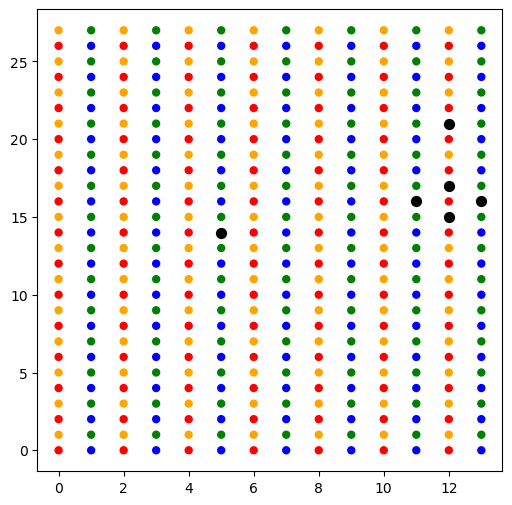

In [522]:
lattice = embed_code((code[8],code[9],code[10],code[11]), 0)
# lattice = embed_code(confirmed_codes[0], 0)

colors = np.empty(lattice.shape, dtype=object)

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            colors[i][j] = "red"
        elif lattice[i][j][0] == "r":
            colors[i][j] = "orange"
        elif lattice[i][j][0] == "l":
            colors[i][j] = "blue"
        else:
            colors[i][j] = "green"

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)



nodes = itertools.product(np.arange(lattice.shape[0]), np.arange(lattice.shape[1]))

gen_qbts = qbts[np.where(Hx[32])[0]] # 20x

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*zip(*nodes), s=25, c=colors.flatten()) # vv qubits
ax.scatter(*zip(*gen_qbts), s=50, c='k')

8 0


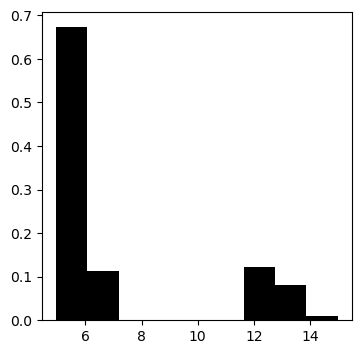

In [523]:
x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

fig, ax = plt.subplots(1, 1, figsize=(4,4))
rs = x_rs
bins = np.linspace(min(rs), max(rs), 10)
counts, _ = np.histogram(rs, bins=bins)
counts_weighter = counts.sum()
ax.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, color='black')
print(np.argmin(rs), np.argmax(rs))

In [524]:
# for i in range(m*ell):
#     nlqbts = []
#     coord = x_checks[i]
#     gen_qbts = qbts[np.where(Hx[i])[0]]
#     for qbt in gen_qbts:
#         if (abs(coord[0]-qbt[0])+ abs(coord[1]-qbt[1]) > 1):
#             nlqbts.append(qbt)
#     if make_circle(gen_qbts)[2] < (min(x_rs)+np.std(x_rs)):
#         print([nlqbts, coord])

# for i in range(m*ell):
#     nlqbts = []
#     coord = z_checks[i]
#     gen_qbts = qbts[np.where(Hz[i])[0]]
#     for qbt in gen_qbts:
#         if (abs(coord[0]-qbt[0])+ abs(coord[1]-qbt[1]) > 1):
#             nlqbts.append(qbt)
#     if make_circle(gen_qbts)[2] < (min(z_rs)+np.std(z_rs)):
#         print([nlqbts, coord])

0.214
21


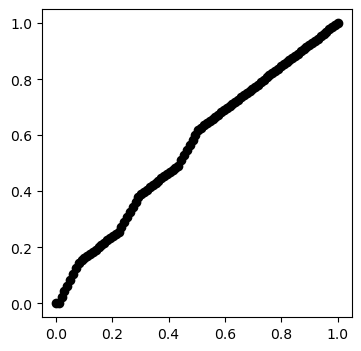

In [525]:
x_rs = np.array([])
z_rs = np.array([])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs = np.append(x_rs, make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs = np.append(z_rs, make_circle(gen_qbts)[2])

x_mask = np.zeros(Hx.shape[0])
for i, x in enumerate(x_rs):
    if (x_rs[i] > (min(x_rs)+np.std(x_rs))):
        x_mask[i] = 1


p_mask = np.round(np.count_nonzero(x_mask)/(m*ell), 3)
adv = (sum(x_rs[x_mask==1])/sum(x_rs))
print(p_mask)
print(np.count_nonzero(x_mask))
# bins = np.linspace(min(rs), max(rs), 20)
# counts, _ = np.histogram(rs, bins=bins)
# counts_weighter = counts.sum()
# plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)
# print(adv)
# print(sum(x_rs))
# print(sum(x_rs[x_mask==1]))
# print(x_rs[x_mask==1])

# x_rs = sorted(x_rs)
fig, ax = plt.subplots(1, 1, figsize=(4,4))
work = [sum((x_rs)[:int(i*len(x_rs))])/sum(x_rs) for i in np.linspace(0,1,100)]
plt.scatter(np.linspace(0,1,100), work, c='k')

In [526]:
arr = []
for i, x in enumerate(x_rs):
    if (x_rs[i] > (min(x_rs)+np.std(x_rs))):
        arr.append(i)
x_mask = np.zeros(Hx.shape[0]).astype(np.uint8)
x_mask[arr] = 1

Hxm = Hx[x_mask == 0]

print(arr)
print(len(arr)/Hx.shape[0])

arr = []
for i, z in enumerate(z_rs):
    if (z > (min(z_rs))+np.std(z_rs)):
        arr.append(i)

z_mask = np.zeros(Hz.shape[0]).astype(np.uint8)
z_mask[arr] = 1

Hzm = Hz[z_mask == 0]
print(arr)
print(len(arr)/Hz.shape[0])
print(len(arr),Hz.shape[0])

[0, 1, 2, 3, 4, 5, 6, 21, 22, 23, 24, 25, 26, 27, 42, 43, 44, 45, 46, 47, 48]
0.21428571428571427
[21, 22, 23, 24, 25, 26, 27, 42, 43, 44, 45, 46, 47, 48, 63, 64, 65, 66, 67, 68, 69]
0.21428571428571427
21 98


In [501]:
def total_time(t, lr_round):
    s = 0

    sr_time = 10
    lr_time = 4
    for i in range(1,t+1):
        if (i % lr_round) == 0:
            s += 2*(sr_time+lr_time)
        else:
            s += 2*sr_time
    return s

t = 100
tt1 = total_time(t,1)
tt5 = total_time(t,5)

pc = ((tt1-tt5)/tt1)*100
print(tt1,tt5)
print(pc)

2800 2160
22.857142857142858
